### Data Import

Downloaded the data file Customer_Service_Questions_Multiclass.csv. This file contains 5000 customer queries at an online retailer, which are classified into seven topics such as "Shipping", "Product Availability", "Returns & Refunds", etc. The job is to build a multi-class classifier that can automatically classify new incoming queries into these topics, so that they can be handled by the appropriate department.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import os
import time

%matplotlib inline

os.chdir(r'C:\Users\sriva\OneDrive\Desktop\ISM6930_Text_Analytics\Raj_Ankit_Assignment04')

In [2]:
customer_service_data = pd.read_csv('Customer_Service_Questions_Multiclass.csv')
print(customer_service_data.shape)
customer_service_data.head()

(5000, 2)


,question,topic
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions
1,I'm going to be out of the country for about a...,Shipping
2,I was wondering if you'd be able to overnight ...,Shipping
3,The Swingline electronic stapler (472555) look...,Shipping
4,I think this cosmetic bag would work great for...,Shipping


### Data Preprocessing

In [3]:
from nltk.tokenize import regexp_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
word_lemmatizer = WordNetLemmatizer()

In [4]:
# Tokenized, cleaned the text of the questions and lemmatized the words
cleaned_question = []
for question in customer_service_data['question']:
    words_in_question = regexp_tokenize(question.lower(), r'[A-Za-z]+')
    words_in_question = [word_lemmatizer.lemmatize(word) for word in words_in_question if word not in stop_words]
    cleaned_question.append(' '.join(words_in_question))

customer_service_data['cleaned_question'] = pd.Series(cleaned_question)
customer_service_data.head()

,question,topic,cleaned_question
0,"Hi! If I sign up for your email list, can I se...",Sales/Promotions,hi sign email list select get email exclusivel...
1,I'm going to be out of the country for about a...,Shipping,going country week travel going getting animal...
2,I was wondering if you'd be able to overnight ...,Shipping,wondering able overnight jacket item trenton nj
3,The Swingline electronic stapler (472555) look...,Shipping,swingline electronic stapler look really great...
4,I think this cosmetic bag would work great for...,Shipping,think cosmetic bag would work great however kn...


In [5]:
customer_service_data.groupby('topic')['cleaned_question'].count()

topic
Omnichannel               450
Product Availability      833
Product Comparison        806
Product Specifications    839
Returns & Refunds         768
Sales/Promotions          505
Shipping                  799
Name: cleaned_question, dtype: int64

In [6]:
# Train-test split, Tfidf vector creation and label encoding of the y variable

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(customer_service_data['cleaned_question'], customer_service_data['topic'],
                                                   test_size = 0.2, random_state = 95)

vector = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features = 5000)
vector = vector.fit(customer_service_data['cleaned_question'])
tfidf_Xtrain = vector.transform(X_train)
tfidf_Xtest = vector.transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Model creation using Linear SVC, XGBoost and Neural Networks Classifiers

##### Linear SVC Classifier

In [7]:
# Imported the required libraries for the multiclass classification model Linear SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

start_time = time.time()

# Hyperparameters tuning
# Used a random state to set the seed, fit_intersept set as false so that no intercept is used in the calculation
# Max iterations set to 1000
svm_model = LinearSVC(random_state = 95, fit_intercept = False, penalty = 'l2', max_iter = 1000)
svm_model.fit(tfidf_Xtrain, y_train)

y_predict_svm = svm_model.predict(tfidf_Xtest)
svm_accuracy = accuracy_score(y_test, y_predict_svm)

print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  1.0251667764451768e-05  seconds


In [8]:
# Imported the required libraries for the boosting ensemble model XGBoost
from xgboost import XGBClassifier

start_time = time.time()

num_classes = np.max(y_train) + 1

# Hyperparameters tuning
# Objective set to do multiclass classification, fit_intersept set as false so that no intercept is used in the calculation
# As the data is large enough, n_estimators set to 100 to limit the number of gradient boosted trees 
# max_depth set to None so that each tree expands until every leaf is pure
# num_classes to set the number of distinct classes for classification

xgb_model = XGBClassifier(objective='multi:softmax', n_estimators = 100, max_depth = None, num_classes = num_classes)
xgb_model.fit(tfidf_Xtrain, y_train)

y_predict_xgb = xgb_model.predict(tfidf_Xtest)
xgb_accuracy = accuracy_score(y_test, y_predict_xgb)

print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  0.006024027466773987  seconds


In [9]:
# Imported the required libraries for the neural network model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras import utils

Using TensorFlow backend.


In [10]:
# Preparing data for the neural network model
text_tokenizer = Tokenizer(char_level = False)
text_tokenizer.fit_on_texts(X_train)

neural_net_Xtrain = text_tokenizer.texts_to_matrix(X_train)
neural_net_Xtest = text_tokenizer.texts_to_matrix(X_test)

neural_net_Ytrain = utils.to_categorical(y_train, num_classes)
neural_net_Ytest = utils.to_categorical(y_test, num_classes)

In [11]:
start_time = time.time()

#Build the neural network model

# Hyperparameters tuning
# Number of hidden units in the first and second layer set to 512 and 256 respectively
# Input shape set as the number of attributes in each row of the training data
# Activation function relu used
# Dropout layer added between the fully connected dense layers to avoid overfitting
# Softmax activation used in the output layer to support multiclass classification

neural_net_model = Sequential()
neural_net_model.add(Dense(512, activation = 'relu', input_shape = (neural_net_Xtrain.shape[1],)))
neural_net_model.add(Dropout(0.5))
neural_net_model.add(Dense(256, activation = 'relu'))
neural_net_model.add(Dropout(0.25))
neural_net_model.add(Dense(num_classes, activation = 'softmax'))

# Model compiled using the optimizer adam and categorical_crossentropy loss function for the metric accuracy 
neural_net_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Batch size set to 128 to limit the number of samples to be shown to the network before a weight update
# Epoch set to 10 to separate training into 10 distinct phases
# Verbose set to 0 to hide the training progress for each epoch
# 10% of the data set apart as validation data to evaluate the loss and any model metrics on the data at the end of each epoch
neural_net_model.fit(neural_net_Xtrain, neural_net_Ytrain, batch_size = 128, epochs = 10, verbose = 0, validation_split = 0.1)

y_predict_nn = neural_net_model.predict(neural_net_Xtest)
nn_accuracy = neural_net_model.evaluate(neural_net_Xtest, neural_net_Ytest, batch_size = 128, verbose = 0)[1]

print('Elapsed clock time: ', time.time() - start_time, ' seconds')

Elapsed clock time:  14.508882999420166  seconds


### Evaluation of the classification models

##### Accuracy comparison

In [12]:
# Printed the accuracy of each classification model in %s
print('Accuracy of Linear SVC Classifier: '+'{:.1%}'.format(svm_accuracy))
print('Accuracy of XGBoost Classifier: '+'{:.1%}'.format(xgb_accuracy))
print('Accuracy of Neural Network Classifier: '+'{:.1%}'.format(nn_accuracy))

Accuracy of Linear SVC Classifier: 95.7%
Accuracy of XGBoost Classifier: 95.1%
Accuracy of Neural Network Classifier: 95.5%


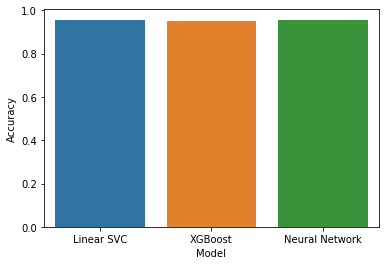

In [13]:
# Stored the model names and their accuracy in a dataframe
# Plotted a barplot for accuracy

classification_models = ['Linear SVC', 'XGBoost', 'Neural Network']
model_accuracy = []
for accuracy in (svm_accuracy, xgb_accuracy, nn_accuracy):
    model_accuracy.append(accuracy)

models_accuracy_df = pd.DataFrame({'Model': classification_models, 'Accuracy': model_accuracy})
bar = sb.barplot(x = 'Model', y = 'Accuracy', data = models_accuracy_df)

Classification Accuracy is simply the number of correct predictions divided by all predictions or a ratio of correct predictions to total predictions.
From the results and the above graph, we can observe that all the classifiers are performing well and have almost the same accuracy of over 95%. Linear SVC, however, has the highest accuracy amongst all the three classifiers and the neural network is just behind by 0.2%.

##### Confusion Matrix

In [14]:
# Created confusion matrices for the 3 models
svm_confusion_matrix = confusion_matrix(y_test, y_predict_svm)
xgb_confusion_matrix = confusion_matrix(y_test, y_predict_xgb)

# Confusion matrix needs both labels & predictions as single-digits 
# Not as one-hot encoded vectors
# Converted them too to single-digit ones for the neural network
y_test_nn_1d = []
y_pred_nn_1d = []

# Iterated over a for loop to populate the single digit list of y_test and y_predict
for i in range(len(neural_net_Ytest)):
    prob_test = neural_net_Ytest[i]
    prob_predict = y_predict_nn[i]
    index_array_test = np.nonzero(prob_test)
    test_index = index_array_test[0].item(0)
    y_test_nn_1d.append(test_index)
    predicted_index = np.argmax(prob_predict)
    y_pred_nn_1d.append(predicted_index)
    
nn_confusion_matrix = confusion_matrix(y_test_nn_1d, y_pred_nn_1d)

In [15]:
# Created dictionaries to store topics and topic ids
customer_service_data['topic_id'] = customer_service_data['topic'].factorize()[0]
topic_data = customer_service_data[['topic', 'topic_id']].drop_duplicates().sort_values('topic_id')
topic_to_id = dict(topic_data.values)
id_to_topic = dict(topic_data[['topic_id', 'topic']].values)

# Created a function to plot the confusion matrices of the 3 models
def plotConfusionMatrix(model_confusion_matrix, model_name, i):
    plt.subplot(i)
    sb.heatmap(model_confusion_matrix, annot = True, fmt = 'd', cmap = 'BuPu',
               xticklabels = topic_data['topic'].values, yticklabels = topic_data['topic'].values)
    plt.title('Confusion Matrix of the %s'%model_name)

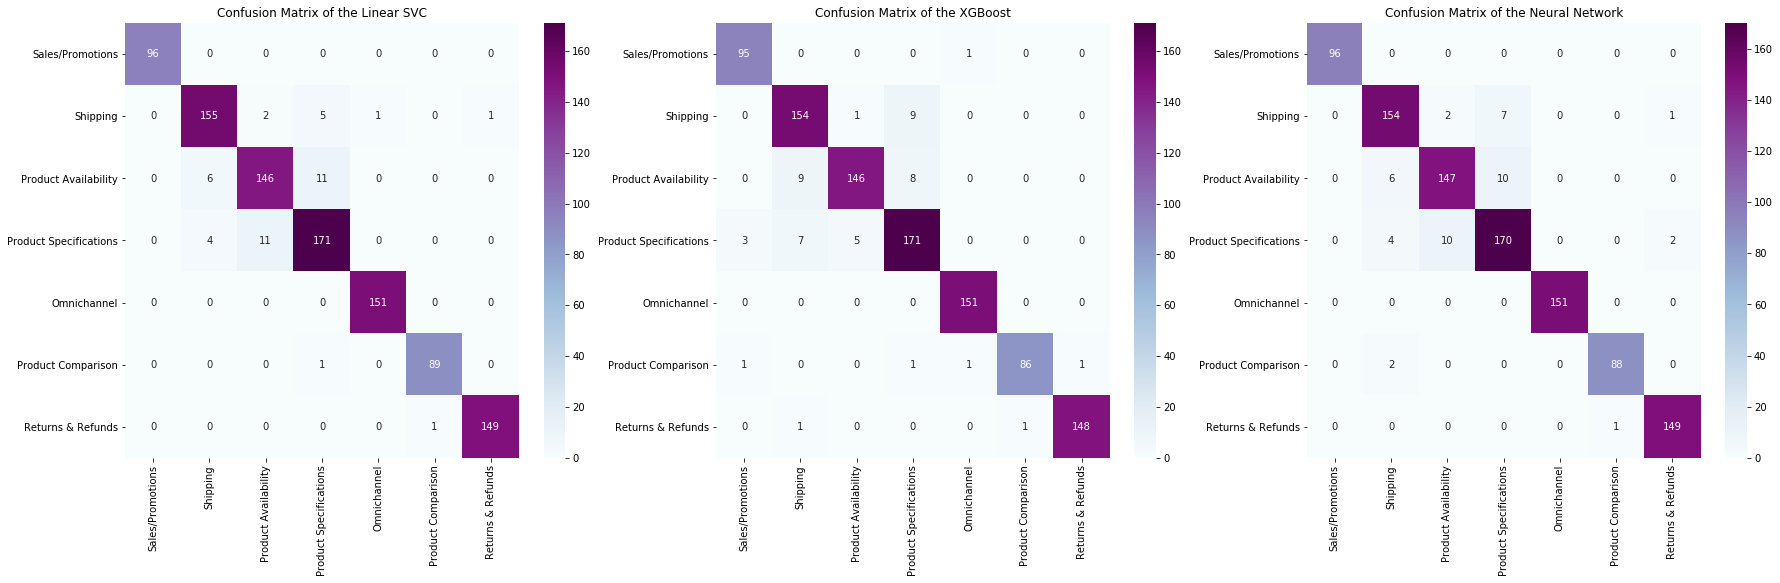

In [16]:
# Plotted the heatmap of the 3 confusion matrices
plt.figure(figsize=(30, 8))
plotConfusionMatrix(svm_confusion_matrix, 'Linear SVC', 131)
plotConfusionMatrix(xgb_confusion_matrix, 'XGBoost', 132)
plotConfusionMatrix(nn_confusion_matrix, 'Neural Network', 133)

plt.show()

As shown in the above heatmaps, number of correct predictions for each classifier is displayed diagonally from left to bottom right.
We can use this to compare how different models are correctly predicting a topic compared to others.

Below are a few noticeable predictions:

* Linear SVC Classifier correctly identified/predicted Product Specifications 171 times. Apart from that, it predicted the topic incorrectly as Product Availability 11 times, and as Shipping 4 times.
* XGBoost Classifier correctly identified/predicted Product Specifications 171 times. Apart from that, it predicted the topic incorrectly as Product Availability 5 times, as Shipping 7 times, and as Sales/Promotions 3 times.
* Neural Network Classifier correctly identified/predicted Product Specifications 172 times. Apart from that, it predicted the topic incorrectly as Product Availability 11 times, and as Shipping 3 times.
        
Similiarly, we can compare the results for other topics. 

##### Evaluation of other metrics using Classification Report

In [17]:
print('Classification Report of Linear SVC:')
print(classification_report(y_test, y_predict_svm))
print('*********************************************************************')
print('Classification Report of Random Forests:')
print(classification_report(y_test, y_predict_xgb))
print('*********************************************************************')
print('Classification Report of Neural Network:')
print(classification_report(y_test_nn_1d, y_pred_nn_1d))

Classification Report of Linear SVC:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       0.94      0.95      0.94       164
           2       0.92      0.90      0.91       163
           3       0.91      0.92      0.91       186
           4       0.99      1.00      1.00       151
           5       0.99      0.99      0.99        90
           6       0.99      0.99      0.99       150

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

*********************************************************************
Classification Report of Random Forests:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        96
           1       0.90      0.94      0.92       164
           2       0.96      0.90      0.93       163
           3       0.90      0.92     

* Precision is the ability of a classiifer not to label an instance positive that is actually negative. 
* Recall is the ability of a classifier to find all positive instances. Said another way, “for all instances that were actually positive, what percent was classified correctly?”
* The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.
* Support is the number of actual occurrences of the class in the specified dataset.

Looking at the results, we can observe that all the 3 classsifiers give almost the same precision and recall values, but Linear SVC provide the best precision and recall values among the 3 classifiers. Even the f1-score is greater than Neural Network and XGBoost Classifier.

##### Tested the prediction accuracy using a random example

In [18]:
# Prediction example, I took a random question from the dataset 
# To check if the models are able to predict the topic correctly

# Created a function to return the prediction
def predictTopic(text, model, isNeural):
    if isNeural == False:
        text_features = vector.transform(text)
        prediction = model.predict(text_features)
    else:
        text_features = text_tokenizer.texts_to_matrix(text)
        prediction = model.predict(text_features)
        prediction = np.argmax(prediction)
    return prediction


question = ["Do you know how much cholesterol is in the whey fuel (034574) has?"]

print('Prediction by Linear SVC Classifier: ', id_to_topic[predictTopic(question, svm_model, isNeural = False)[0]])
print('Prediction by XGBoost Classifier: ', id_to_topic[predictTopic(question, xgb_model, isNeural = False)[0]])
print('Prediction by Neural Network Classifier: ', id_to_topic[predictTopic(question, neural_net_model, isNeural = True)])

Prediction by Linear SVC Classifier:  Product Specifications
Prediction by XGBoost Classifier:  Product Specifications
Prediction by Neural Network Classifier:  Product Specifications


We can see that all the classifiers are able to predict the topic correctly.

Overall, we observed that although the performances of all the 3 classifiers were good but Linear SVC slighlty outperformed others. The precision, recall and F-score for all the categories is slightly better in Linear SVC classifier.
And moreover, Linear SVC is the fastest among the 3 with an elapsed time of 1.1.0251667764451768e-05 seconds and has the highest accuracy of 95.7%.